# Frequency-Domain BSS -- Boilerplate



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import sys, os

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from scipy.signal import stft
from scipy.io import wavfile
import scipy
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
BASE_PATH = '/content/drive/My Drive/blind_source_separation/'
MODULE_DIR = os.path.join(BASE_PATH,'modules')
sys.path.append(BASE_PATH)
sys.path.append(MODULE_DIR)
os.listdir(MODULE_DIR)

['__pycache__',
 'separation.py',
 'permutation.py',
 'clustering.py',
 'auxiliaries.py']

In [ ]:
from permutation import *
from clustering import *
from separation import *
from auxiliaries import *

# Load Wave Files

https://cnl.salk.edu/~tewon/Blind/blind_audio.html

In [ ]:
fs, waveA = wavfile.read(os.path.join(BASE_PATH,'data/mixed/rss_mA.wav'))
_, waveB = wavfile.read(os.path.join(BASE_PATH,'data/mixed/rss_mB.wav'))

X = np.vstack([waveA,waveB])

print_characteristics([waveA, waveB, fs, X])

type:	<class 'numpy.ndarray'>
shape:	(119000,)
dtype:	int16

type:	<class 'numpy.ndarray'>
shape:	(119000,)
dtype:	int16

type:	<class 'int'>

type:	<class 'numpy.ndarray'>
shape:	(2, 119000)
dtype:	int16



# STFT

Zxx: STFT of x. By default, the last axis of Zxx corresponds to the segment times.

t: Array of segment times.

f: Array of sample frequencies.

In [ ]:
f, t, Zxx = stft(X, fs, nperseg=1000)
print_characteristics([f,t,Zxx])

type:	<class 'numpy.ndarray'>
shape:	(501,)
dtype:	float64

type:	<class 'numpy.ndarray'>
shape:	(239,)
dtype:	float64

type:	<class 'numpy.ndarray'>
shape:	(2, 501, 239)
dtype:	complex64



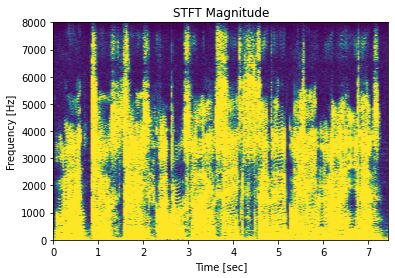

In [ ]:
vmax=10
plt.pcolormesh(t, f, np.abs(Zxx[0]), vmin=0, vmax=vmax, shading='gouraud')
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

In [ ]:
from tqdm.notebook import trange, tqdm
from time import sleep

@timit
def source_separation(Zxx, f, Wf=[], Yf=[]):
  for i in trange(len(f), desc='1st loop'):
    x_f = Zxx[:,i,:]
    V, Z = whitening(x_f)
    U, Y = complex_FastICA(Z, history=False)
    W, Y = MLE(x_f, V, U, max_iter=int(1e3), step_size=1e-4, tol=1e-6, history=False)
    Wf.append([W, f[i]])
    Yf.append([Y, f[i]])
  return Wf, Yf

In [ ]:
Wf, Yf = source_separation(Zxx, f)

print_characteristics([Wf, Yf])

/content/drive/My Drive/blind_source_separation/modules/separation.py:107: UserWarning: MLE did not converge.
  warnings.warn('MLE did not converge.')
/content/drive/My Drive/blind_source_separation/modules/separation.py:66: UserWarning: FastICA did not converge.
  warnings.warn('FastICA did not converge.')



func:source_separation
runtime: 141.9941 s
type:	<class 'list'>

type:	<class 'list'>



# TDOA: Permutation problem

Cut off low frequencies. They lead to unstable estimators.

In [ ]:
## todo add frequency threshold
print(len(Wf))

501


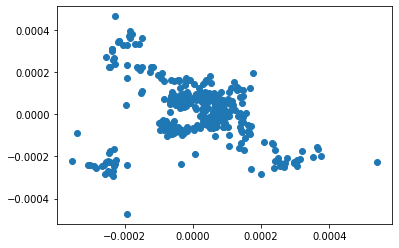

In [ ]:
Wf_ = Wf[int(0.1*len(Wf)):]

rf_est = TDOA_estimator(Wf_)

plt.scatter(rf_est[:,0],rf_est[:,1])
plt.show()

In [ ]:
rf_flat = np.reshape(rf_est,(-1,1))
print(rf_flat.shape)

(902, 1)


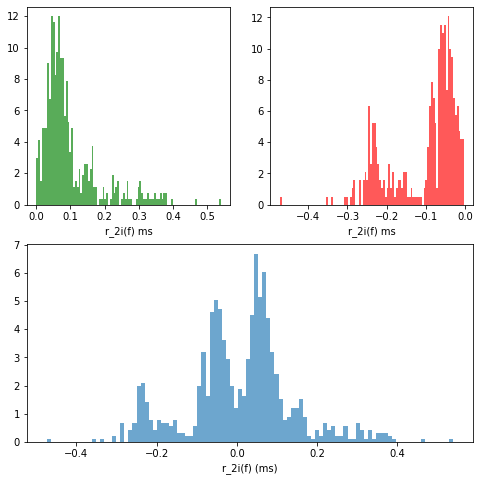

In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2)
kmeans.fit(rf_flat)
y_pred = kmeans.predict(rf_flat)

def plot_hist(r,y_pred):
  cluster_1 = r[y_pred==0]
  cluster_2 = r[y_pred==1]

  plt.figure(figsize=(8,8))

  kwargs = {'bins': 100, 'density': True, 'alpha': 0.65}

  ax0 = plt.subplot(212)
  ax0.hist(1000*r, **kwargs)
  ax0.set_xlabel('r_2i(f) (ms)')

  ax1 = plt.subplot(221)
  ax1.hist(1000*cluster_1, facecolor='g', **kwargs)
  ax1.set_xlabel('r_2i(f) ms')

  ax2 = plt.subplot(222)
  ax2.hist(1000*cluster_2, facecolor='r', **kwargs)
  ax2.set_xlabel('r_2i(f) ms')

  plt.show()

plot_hist(rf_flat,y_pred)

In [ ]:
cs=[]
for j in range(100):
  c = init_centers(rf_est)
  for i in range(100):
    c_ = c
    perms = find_permutations(rf_est, c)
    c = update_centroids(rf_est,perms)
    if c_.any()==c.any():
      break
  cs.append(c)

In [52]:
def return_class(r,c):
  dist = r-c
  ind = np.argmin(dist,axis=1)
  return ind

In [55]:
y_pred = return_class(rf_est,c)
print(y_pred.shape)

(451,)


In [68]:
cluster_1=[]
cluster_2=[]
for i in range(len(rf_est)):
  if y_pred[i]==1:
    cluster_1.append(rf_est[i,0])
    cluster_2.append(rf_est[i,1])
  else:
    cluster_1.append(rf_est[i,1])
    cluster_2.append(rf_est[i,0])

451


# Analyse Data

In [126]:
print((abs(rf_est[:,1]-rf_est[:,0])).max())
print((abs(rf_est[:,1]-rf_est[:,0])).min())
print((abs(rf_est[:,1]-rf_est[:,0])).mean())
print(((rf_est[:,1]-rf_est[:,0])).var())

0.0007627704381342119
3.970663723673628e-07
0.00013685589501151972
4.3230601733942416e-08


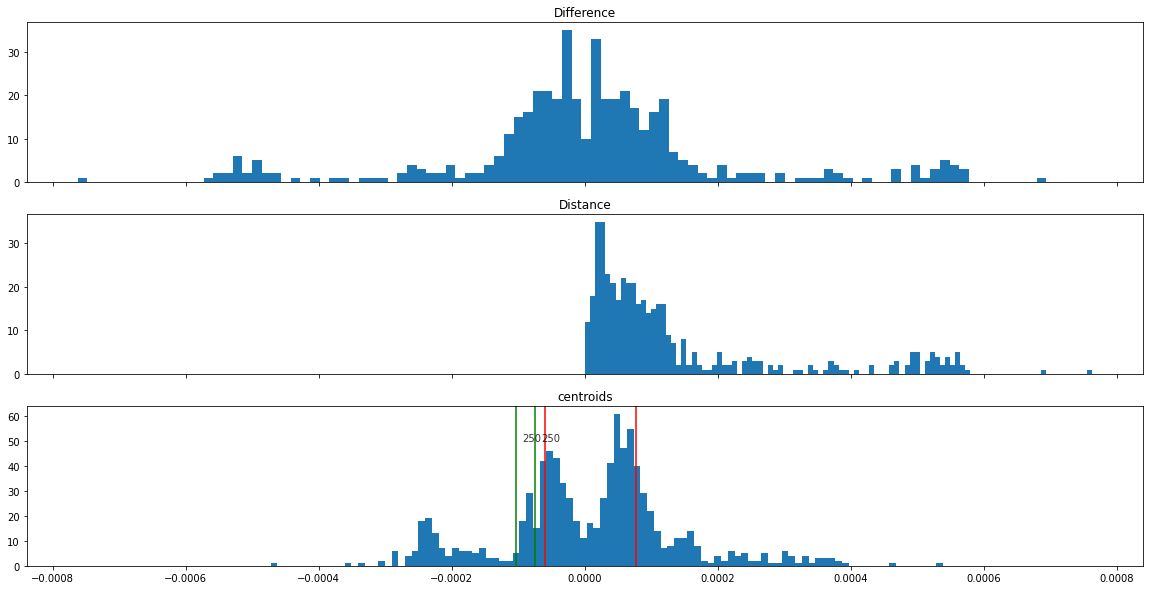

In [181]:
ii=250

fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, sharex=True,
                                    figsize=(20, 10))
ax1.hist((rf_est[:,1]-rf_est[:,0]),bins=100)
ax1.set_title('Difference')

ax2.hist(abs(rf_est[:,1]-rf_est[:,0]),bins=100)
ax2.set_title('Distance')

ax3.hist(rf_est.flatten(),bins=100)
ax3.axvline(c[0,0],color='r')
ax3.axvline(c[0,1],color='r')
ax3.axvline(rf_est[ii,0],color='g')
ax3.axvline(rf_est[ii,1],color='g')
ax3.set_title("centroids")
ax3.text(rf_est[ii,0]+0.00001, 50, str(ii), size = 10, alpha = 0.8)
ax3.text(rf_est[ii,1]+0.00001, 50, str(ii), size = 10, alpha = 0.8)
plt.show()

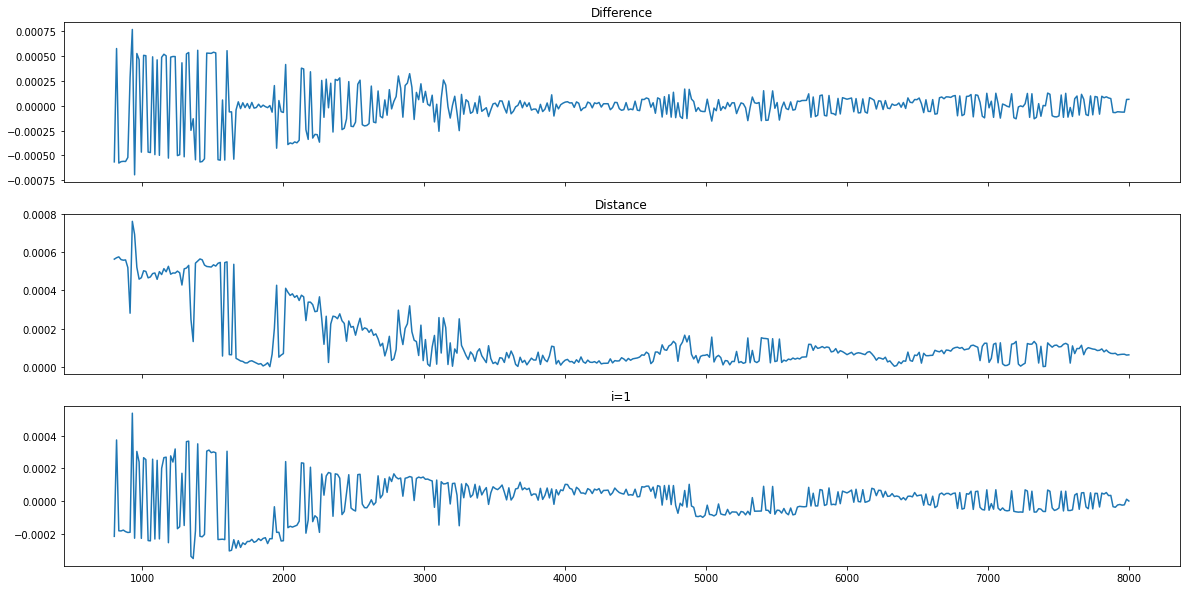

In [163]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, ncols=1, sharex=True,
                                    figsize=(20, 10))

ax0.plot(f[50:],(rf_est[:,0]-rf_est[:,1]))
ax0.set_title('Difference')
ax1.plot(f[50:],abs(rf_est[:,0]-rf_est[:,1]))
ax1.set_title('Distance')
ax2.plot(f[50:],rf_est[:,0])
ax2.set_title('i=1')
plt.show()